In [1]:
import os, sys, random, pandas as pd, numpy as np
from tqdm import tqdm
import torch


# set random seed
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
sys.path.append('../')


# load package requirments
from VGFM.utils import  generate_steps, parser, _valid_criterions
from VGFM.plots import plot_comparision
from VGFM.train import pretrain, train
from VGFM.models import  FNet, ODEFunc2
from VGFM.constants import DATA_DIR
from VGFM.exp import setup_exp
from VGFM.eval import generate_plot_data
from torchdiffeq import odeint_adjoint as odeint

### Defining parameters and loading dataset

In [14]:
import torch.optim as optim

dim=2000
f_net = FNet(in_out_dim=dim, hidden_dim=512, n_hiddens=5, activation='leakyrelu')

import sys

# Simulate the command-line arguments
sys.argv = [
    'VGFM Training',
    '-d', 'file',
    '-c', 'ot1',
    '-n', 'pancreas_final',
    '--no-hold-one-out',
    '-ho', '-1',
    '-e1', '10000',
    '-e2', '30',
    '-bs', '1024',
    '-r', '0.01',
    '-rm', '0.1',
    '--norm_cost',
    '--n_big_batches', '5',
]

args = parser.parse_args()
opts = vars(args)

# Display the parsed arguments
print(opts)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


{'dataset': 'file', 'time_col': None, 'name': 'pancreas_final', 'output_dir': 'd:\\NeurIPS_2025_VGFM\\VGFM\\results', 'criterion': 'ot1', 'sample_with_replacement': False, 'hold_one_out': False, 'hold_out': -1, 'apply_losses_in_time': True, 'learning_rate1': 0.001, 'epochs1': 10000, 'norm_cost': True, 'reg': 0.01, 'reg_m': 0.1, 'n_big_batches': 5, 'n_batch': 1024, 'learning_rate2': 0.0001, 'epochs2': 30}


device(type='cpu')

In [15]:
df_all = pd.read_csv(DATA_DIR + '/pancrease_2000d.csv')
df_all=df_all.iloc[:,:dim+3]
 # make output dir
if not os.path.isdir(opts['output_dir']):
    os.makedirs(opts['output_dir'])
exp_dir, logger = setup_exp(opts['output_dir'], opts, opts['name'])
  # load dataset
logger.info(f'Loading dataset: '+opts['name'])


In [16]:
df_all.columns=["cell_type","branch",'samples']+['x'+str(i+1) for i in range(dim)]
df = df_all.drop(columns=['cell_type','branch'])

In [17]:
df

,samples,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x1991,x1992,x1993,x1994,x1995,x1996,x1997,x1998,x1999,x2000
0,0,3.717023,0.000000,2.279082,6.912693,0.000000,10.251488,4.974458,0.000000,7.652618,...,0.0,0.000000,0.000000,0.000000,0.000000,1.437941,0.000000,0.000000,0.000000,0.000000
1,0,4.007041,3.214371,3.763014,1.279916,3.074543,3.620895,0.784777,3.509280,0.495139,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,1.864270,1.477399,1.308417,0.738699,2.371100,2.694503,0.000000,2.047116,0.738699,...,0.0,0.000000,0.932135,0.000000,0.466067,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,2.443856,1.629238,1.629238,2.920378,1.629238,6.526097,3.396899,1.291140,5.807648,...,0.0,0.000000,0.814619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,0.970503,1.538211,0.970503,1.941007,0.970503,6.170025,5.585137,1.538211,1.538211,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.970503,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18391,1,5.520655,3.380276,3.112498,0.000000,2.795784,7.453035,0.000000,2.795784,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18392,1,4.926593,4.835765,4.322890,1.179245,4.219582,3.313142,0.000000,3.732221,0.804960,...,0.0,0.000000,0.507873,0.000000,0.000000,0.507873,0.000000,0.000000,0.000000,0.000000
18393,1,3.410840,2.752826,2.752826,4.394247,1.179083,5.681028,0.743919,1.487838,5.015104,...,0.0,0.000000,1.727326,0.000000,0.000000,0.000000,0.000000,0.000000,0.743919,0.743919
18394,1,4.275737,2.557335,2.967937,5.979793,0.989312,8.381132,0.000000,1.568023,3.422458,...,0.0,0.000000,0.000000,0.989312,0.989312,0.000000,0.989312,0.000000,0.989312,0.000000


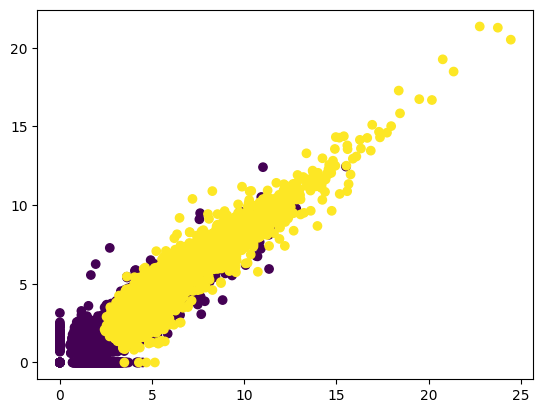

In [18]:
import matplotlib.pyplot as plt
plt.scatter(df.iloc[:,1],df.iloc[:,2],c=df.iloc[:,0])

In [19]:
groups = sorted([g for g in df.samples.unique() if g != args.hold_out])
steps = generate_steps(groups)
optimizer = torch.optim.Adam(f_net.parameters())
opts['criterion']='ot1'
criterion =  _valid_criterions[opts['criterion']]()

# # logger.info(f'Extracting parameters')
use_cuda = torch.cuda.is_available()
# sample_with_replacement = opts['sample_with_replacement' ]
# apply_losses_in_time = opts['apply_losses_in_time']

    
local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []

In [20]:
f_net=f_net.to(device)

In [21]:
initial_size=df[df['samples']==0].x1.shape[0]
initial_size

8424

In [22]:
sample_sizes = df.groupby('samples').size()
ref0 = sample_sizes / sample_sizes.iloc[0]  
relative_mass = torch.tensor(ref0.values) 
relative_mass

tensor([1.0000, 1.1838], dtype=torch.float64)

In [24]:
sample_size = (np.round(1/args.n_big_batches*(len(df[df['samples']==0]))).astype(int),)
sample_size

(1685,)

### Training with $\mathcal{L}_{\rm VGFM}$

In [35]:
f_net, v_losses, g_losses, losses = pretrain(
    f_net,
    df,
    optimizer,
    n_epoch=args.epochs1,
    hold_out=args.hold_out,
    logger=logger,
    relative_mass=relative_mass,
    reg=args.reg,
    reg_m=[args.reg_m, np.inf],
    norm_cost=args.norm_cost,
    batch_size=args.n_batch
)


relative_mass tensor([1.0000, 1.1838], dtype=torch.float64)
t_train: [0, 1]


Begin flow and growth matching...: 100%|██████████| 10000/10000 [31:41<00:00,  5.26epoch/s, loss=0.326234, vloss=0.321917, gloss=0.004317]


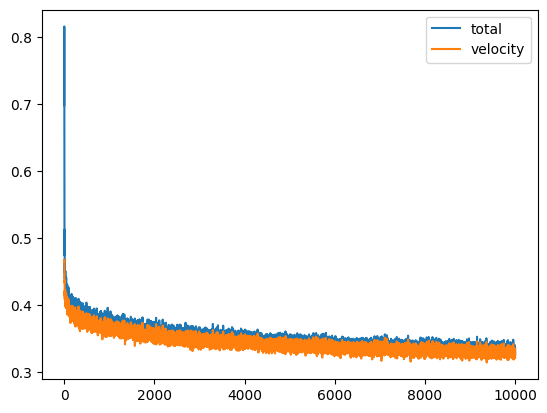

In [38]:
import matplotlib.pyplot as plt
plt.plot(losses,label='total')
plt.plot(v_losses,label='velocity')
# plt.plot(g_losses,label='growth')
plt.legend()

In [39]:
torch.save(f_net.state_dict(), os.path.join(exp_dir+'/pretrain_best_model'))

In [25]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/pretrain_best_model'),map_location=torch.device('cpu')))
optimizer = torch.optim.Adam(f_net.parameters(),lr=args.learning_rate2)

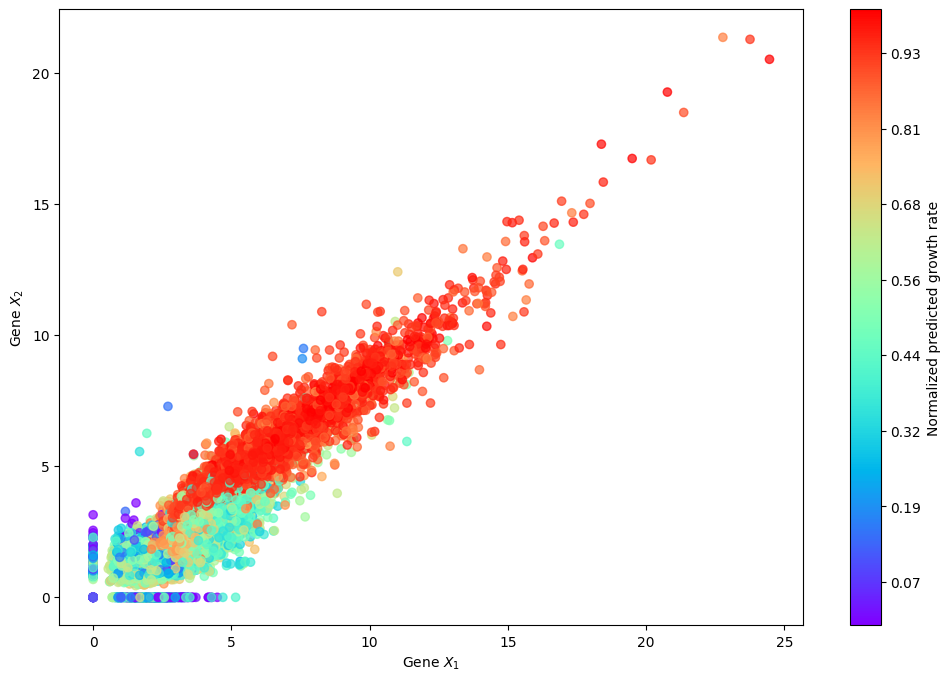

In [32]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 2000

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 99)
    vmin_value = np.percentile(all_g_values, 1)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_pretrain.pdf')

### Incorporating $\mathcal{L}_{\rm OT}$

In [27]:
logger.info("Incorporating $L_{ot}$")

# 训练阶段
l_loss, b_loss, g_loss = train(
    f_net,
    df,
    groups,
    optimizer,
    args.epochs2,  # n_epoch
    criterion=criterion,
    use_cuda=use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out,
    hold_out=args.hold_out,
    sample_size=sample_size,
    relative_mass=relative_mass,
    initial_size=initial_size,
    sample_with_replacement=args.sample_with_replacement,
    logger=logger,
    device=device,
    best_model_path=exp_dir + "/best_model",
    stepsize=0.1,
    n_big_batch=args.n_big_batches
)

# 累积损失
for k, v in l_loss.items():
    local_losses[k].extend(v)

batch_losses.extend(b_loss)
globe_losses.extend(g_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:1.1535831689834595,relative_mass_now:1.1837606837606838
RME:0.02549291862047107
Otloss:27.0024
total loss:27.0024


d:\NeurIPS_2025_VGFM\VGFM\notebooks\..\VGFM\train.py:201: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  batch_loss = torch.Tensor(batch_loss).float()
  3%|▎         | 1/30 [00:01<00:48,  1.67s/it]

New minimum otloss found: 27.002431869506836. Model saved.
epoch_1_0:
relative_mass_pred:1.14744234085083,relative_mass_now:1.1837606837606838
RME:0.03068047740399193
Otloss:26.2307
total loss:26.2307


  7%|▋         | 2/30 [00:03<00:47,  1.68s/it]

New minimum otloss found: 26.230703353881836. Model saved.
epoch_2_0:
relative_mass_pred:1.1699721813201904,relative_mass_now:1.1837606837606838
RME:0.01164804899305214
Otloss:25.3621
total loss:25.3621


 10%|█         | 3/30 [00:05<00:45,  1.67s/it]

New minimum otloss found: 25.362092971801758. Model saved.
epoch_3_0:
relative_mass_pred:1.1816322803497314,relative_mass_now:1.1837606837606838
RME:0.0017980014374109924
Otloss:24.8236
total loss:24.8236


 13%|█▎        | 4/30 [00:06<00:43,  1.66s/it]

New minimum otloss found: 24.823570251464844. Model saved.
epoch_4_0:
relative_mass_pred:1.1696720123291016,relative_mass_now:1.1837606837606838
RME:0.01190162135375537
Otloss:25.293
total loss:25.293


 17%|█▋        | 5/30 [00:08<00:41,  1.65s/it]

epoch_5_0:
relative_mass_pred:1.1915477514266968,relative_mass_now:1.1837606837606838
RME:0.00657824488753445
Otloss:25.1651
total loss:25.1651


 20%|██        | 6/30 [00:09<00:39,  1.64s/it]

epoch_6_0:
relative_mass_pred:1.174929141998291,relative_mass_now:1.1837606837606838
RME:0.007460580405775832
Otloss:25.1833
total loss:25.1833


 23%|██▎       | 7/30 [00:11<00:37,  1.63s/it]

epoch_7_0:
relative_mass_pred:1.1971335411071777,relative_mass_now:1.1837606837606838
RME:0.011296926422669988
Otloss:25.1756
total loss:25.1756


 27%|██▋       | 8/30 [00:13<00:35,  1.63s/it]

epoch_8_0:
relative_mass_pred:1.1917754411697388,relative_mass_now:1.1837606837606838
RME:0.006770589291403859
Otloss:24.9825
total loss:24.9825


 30%|███       | 9/30 [00:14<00:34,  1.63s/it]

epoch_9_0:
relative_mass_pred:1.204967737197876,relative_mass_now:1.1837606837606838
RME:0.01791498377004684
Otloss:24.7415
total loss:24.7415


 33%|███▎      | 10/30 [00:16<00:32,  1.63s/it]

New minimum otloss found: 24.741483688354492. Model saved.
epoch_10_0:
relative_mass_pred:1.2015739679336548,relative_mass_now:1.1837606837606838
RME:0.01504804511362894
Otloss:24.7117
total loss:24.7117


 37%|███▋      | 11/30 [00:18<00:30,  1.62s/it]

New minimum otloss found: 24.711732864379883. Model saved.
epoch_11_0:
relative_mass_pred:1.178092360496521,relative_mass_now:1.1837606837606838
RME:0.004788403046260253
Otloss:25.0559
total loss:25.0559


 40%|████      | 12/30 [00:19<00:29,  1.61s/it]

epoch_12_0:
relative_mass_pred:1.2009904384613037,relative_mass_now:1.1837606837606838
RME:0.014555099638790849
Otloss:24.8443
total loss:24.8443


 43%|████▎     | 13/30 [00:21<00:27,  1.62s/it]

epoch_13_0:
relative_mass_pred:1.2049247026443481,relative_mass_now:1.1837606837606838
RME:0.01787862967067676
Otloss:24.7239
total loss:24.7239


 47%|████▋     | 14/30 [00:22<00:25,  1.62s/it]

epoch_14_0:
relative_mass_pred:1.191924810409546,relative_mass_now:1.1837606837606838
RME:0.006896771248497246
Otloss:24.6549
total loss:24.6549


 50%|█████     | 15/30 [00:24<00:24,  1.62s/it]

New minimum otloss found: 24.65485382080078. Model saved.
epoch_15_0:
relative_mass_pred:1.2015708684921265,relative_mass_now:1.1837606837606838
RME:0.015045426812843285
Otloss:24.4804
total loss:24.4804


 53%|█████▎    | 16/30 [00:26<00:22,  1.61s/it]

New minimum otloss found: 24.480369567871094. Model saved.
epoch_16_0:
relative_mass_pred:1.188640832901001,relative_mass_now:1.1837606837606838
RME:0.0041225808622174205
Otloss:24.7048
total loss:24.7048


 57%|█████▋    | 17/30 [00:27<00:20,  1.61s/it]

epoch_17_0:
relative_mass_pred:1.1923428773880005,relative_mass_now:1.1837606837606838
RME:0.007249939742931809
Otloss:24.8501
total loss:24.8501


 60%|██████    | 18/30 [00:29<00:19,  1.61s/it]

epoch_18_0:
relative_mass_pred:1.1875264644622803,relative_mass_now:1.1837606837606838
RME:0.003181201025897404
Otloss:24.5344
total loss:24.5344


 63%|██████▎   | 19/30 [00:30<00:17,  1.61s/it]

epoch_19_0:
relative_mass_pred:1.202533483505249,relative_mass_now:1.1837606837606838
RME:0.015858610614542485
Otloss:24.5971
total loss:24.5971


 67%|██████▋   | 20/30 [00:32<00:16,  1.61s/it]

epoch_20_0:
relative_mass_pred:1.186150312423706,relative_mass_now:1.1837606837606838
RME:0.0020186754770657534
Otloss:24.6872
total loss:24.6872


 70%|███████   | 21/30 [00:34<00:14,  1.61s/it]

epoch_21_0:
relative_mass_pred:1.2071309089660645,relative_mass_now:1.1837606837606838
RME:0.019742356310682597
Otloss:24.7891
total loss:24.7891


 73%|███████▎  | 22/30 [00:35<00:12,  1.62s/it]

epoch_22_0:
relative_mass_pred:1.2060675621032715,relative_mass_now:1.1837606837606838
RME:0.018844077733449545
Otloss:24.5525
total loss:24.5525


 77%|███████▋  | 23/30 [00:37<00:11,  1.61s/it]

epoch_23_0:
relative_mass_pred:1.186342477798462,relative_mass_now:1.1837606837606838
RME:0.0021810101257764792
Otloss:24.7272
total loss:24.7272


 80%|████████  | 24/30 [00:38<00:09,  1.61s/it]

epoch_24_0:
relative_mass_pred:1.1801100969314575,relative_mass_now:1.1837606837606838
RME:0.00308388923479763
Otloss:24.8708
total loss:24.8708


 83%|████████▎ | 25/30 [00:40<00:08,  1.61s/it]

epoch_25_0:
relative_mass_pred:1.1799523830413818,relative_mass_now:1.1837606837606838
RME:0.0032171204632370164
Otloss:24.6969
total loss:24.6969


 87%|████████▋ | 26/30 [00:42<00:06,  1.61s/it]

epoch_26_0:
relative_mass_pred:1.195111632347107,relative_mass_now:1.1837606837606838
RME:0.009588887975534366
Otloss:24.3449
total loss:24.3449


 90%|█████████ | 27/30 [00:43<00:04,  1.60s/it]

New minimum otloss found: 24.344947814941406. Model saved.
epoch_27_0:
relative_mass_pred:1.1812307834625244,relative_mass_now:1.1837606837606838
RME:0.0021371720930299285
Otloss:24.6774
total loss:24.6774


 93%|█████████▎| 28/30 [00:45<00:03,  1.60s/it]

epoch_28_0:
relative_mass_pred:1.1877920627593994,relative_mass_now:1.1837606837606838
RME:0.0034055692624529233
Otloss:24.5669
total loss:24.5669


 97%|█████████▋| 29/30 [00:46<00:01,  1.60s/it]

epoch_29_0:
relative_mass_pred:1.1828460693359375,relative_mass_now:1.1837606837606838
RME:0.0007726345681972134
Otloss:24.7963
total loss:24.7963


100%|██████████| 30/30 [00:48<00:00,  1.62s/it]


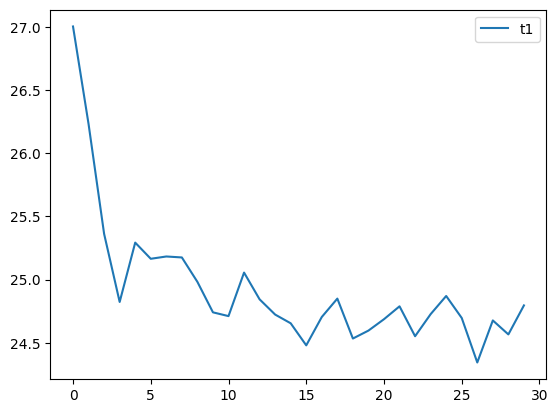

In [28]:
import os
import matplotlib.pyplot as plt

# 假设你已有变量：l_loss 和 exp_dir
plt.plot(l_loss['0:1'], label='t1')
plt.legend()

# 拼接保存路径
save_path = os.path.join(exp_dir, 'emd_train_each_tp.png')
plt.savefig(save_path)

### Test

In [29]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
l_loss, b_loss, g_loss = train(
    f_net, df, groups, optimizer, 1, 
    criterion = criterion, use_cuda = use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out, hold_out=args.hold_out, 
    sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
    sample_with_replacement = args.sample_with_replacement, logger=logger, device=device, best_model_path=exp_dir+'/test_model',stepsize=0.1
)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:1.2014479637145996,relative_mass_now:1.1837606837606838
RME:0.014941601116304352
Otloss:24.4169
total loss:24.4169


100%|██████████| 1/1 [00:05<00:00,  5.02s/it]

New minimum otloss found: 24.416898727416992. Model saved.


In [33]:
# generate plot data
f_net.to('cpu')
generated, trajectories, generated_weights, trajectories_weights = generate_plot_data(
    f_net, df, n_points=1000, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])
<class 'torch.Tensor'>


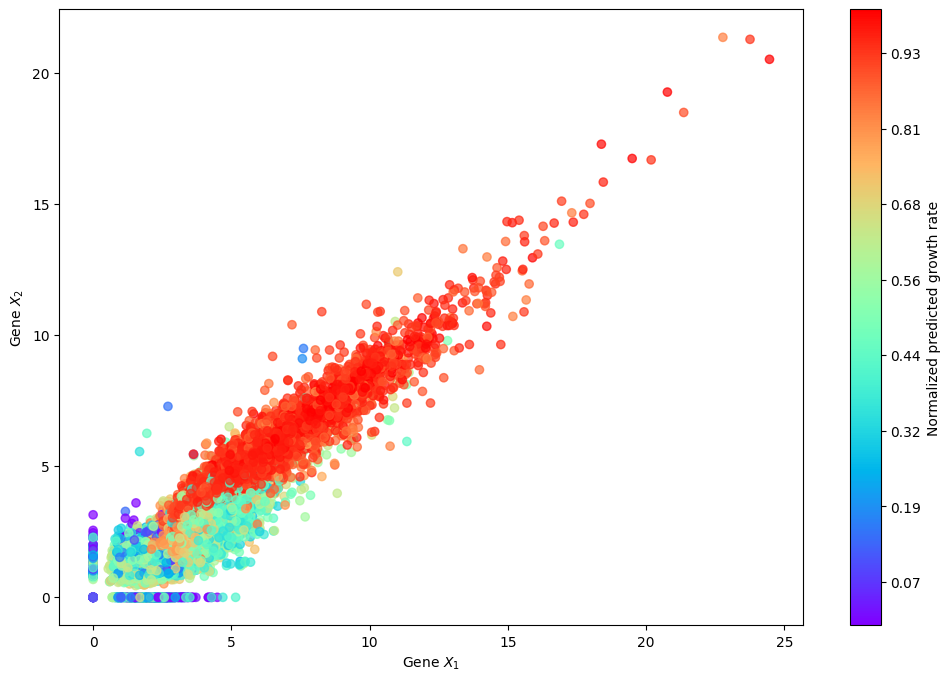

In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 2000

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 99)
    vmin_value = np.percentile(all_g_values, 1)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_final.pdf')

## Deeper analysis

In [81]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))

<All keys matched successfully>

### Analysis on mean and variance

In [79]:
# generate plot data
f_net.to('cpu')
generated, trajectories,_,_ = generate_plot_data(
    f_net, df, n_points=initial_size, n_trajectories=50, n_bins=100, 
    sample_with_replacement=False, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])
<class 'torch.Tensor'>


In [80]:
np.save(exp_dir+'/generated_pretrain.npy', generated)

In [82]:
generated = np.load(exp_dir+'/generated_final.npy')
generate_pretrain = np.load(exp_dir+'/generated_pretrain.npy')

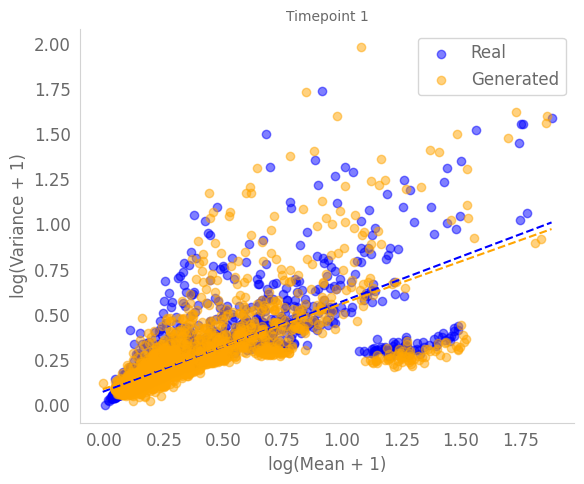

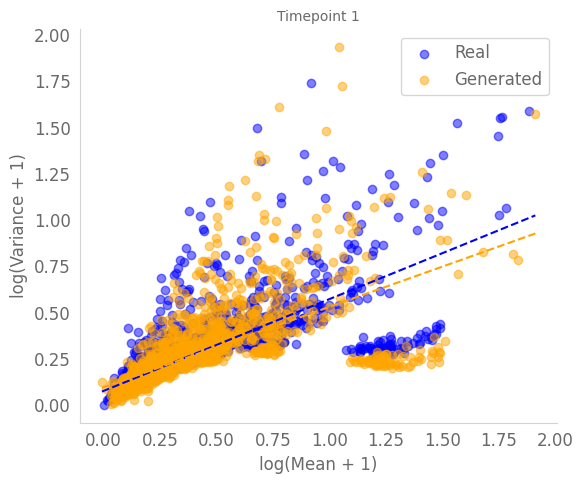

In [87]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_mean_var_scatter(generated: np.ndarray, df: pd.DataFrame, timepoint: int = 1, save_dir=None,name=None):
    """
    Scatter plot of log-transformed mean vs variance for real and generated data
    at a specific timepoint. Includes regression lines for each.
    
    Args:
        generated (np.ndarray): Generated data array, shape (time, samples, features)
        df (pd.DataFrame): Real data DataFrame with 'samples' column
        timepoint (int): Time point to plot
    """
    # Extract generated data for the specific timepoint
    gen_vals = generated[timepoint, :, :]
    gen_mean = gen_vals.mean(axis=0)
    gen_var = gen_vals.var(axis=0)

    # Extract real data for the specific timepoint
    real_vals = df[df['samples'] == timepoint].iloc[:, 1:].values
    real_mean = real_vals.mean(axis=0)
    real_var = real_vals.var(axis=0)

    # Log1p transform
    log_gen_mean = np.log1p(gen_mean)
    log_gen_var = np.log1p(gen_var)
    log_real_mean = np.log1p(real_mean)
    log_real_var = np.log1p(real_var)

    # Scatter plot
    plt.figure(figsize=(6, 5))
    plt.scatter(log_real_mean, log_real_var, alpha=0.5, label='Real', color='blue')
    plt.scatter(log_gen_mean, log_gen_var, alpha=0.5, label='Generated', color='orange')

    # Add regression lines
    slope_r, intercept_r, *_ = linregress(log_real_mean, log_real_var)
    slope_g, intercept_g, *_ = linregress(log_gen_mean, log_gen_var)
    x_vals = np.linspace(min(log_real_mean.min(), log_gen_mean.min()),
                         max(log_real_mean.max(), log_gen_mean.max()), 100)
    plt.plot(x_vals, slope_r * x_vals + intercept_r, color='blue', linestyle='--')
    plt.plot(x_vals, slope_g * x_vals + intercept_g, color='orange', linestyle='--')

    # Labels and title
    plt.title(f'Timepoint {timepoint}')
    plt.xlabel('log(Mean + 1)')
    plt.ylabel('log(Variance + 1)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'mean_var_scatter_{name}.png'), dpi=300)

# Example usage
plot_mean_var_scatter(generated, df, timepoint=1,save_dir=exp_dir,name='final')
plot_mean_var_scatter(generate_pretrain, df, timepoint=1,save_dir=exp_dir,name='pretrain')


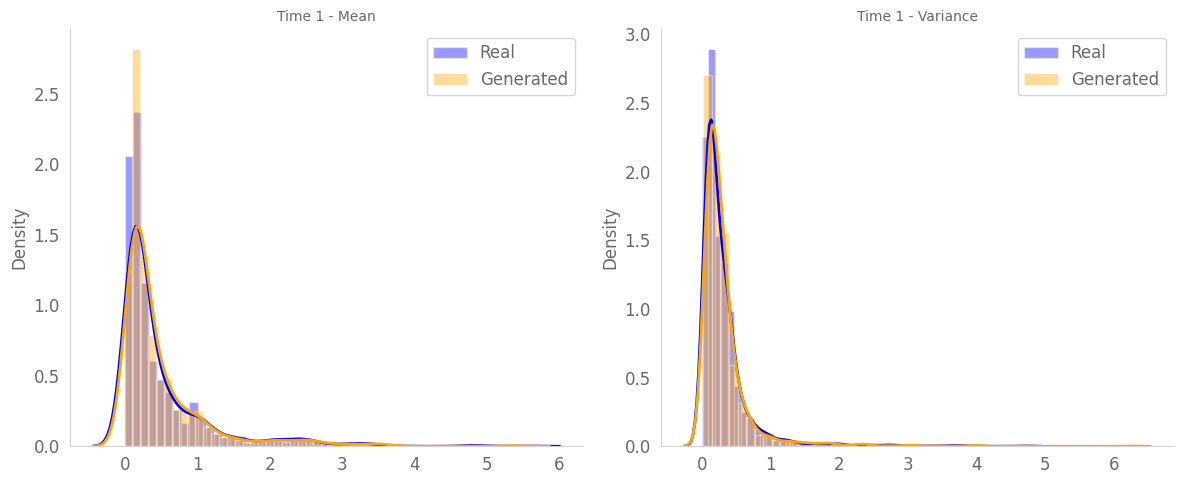

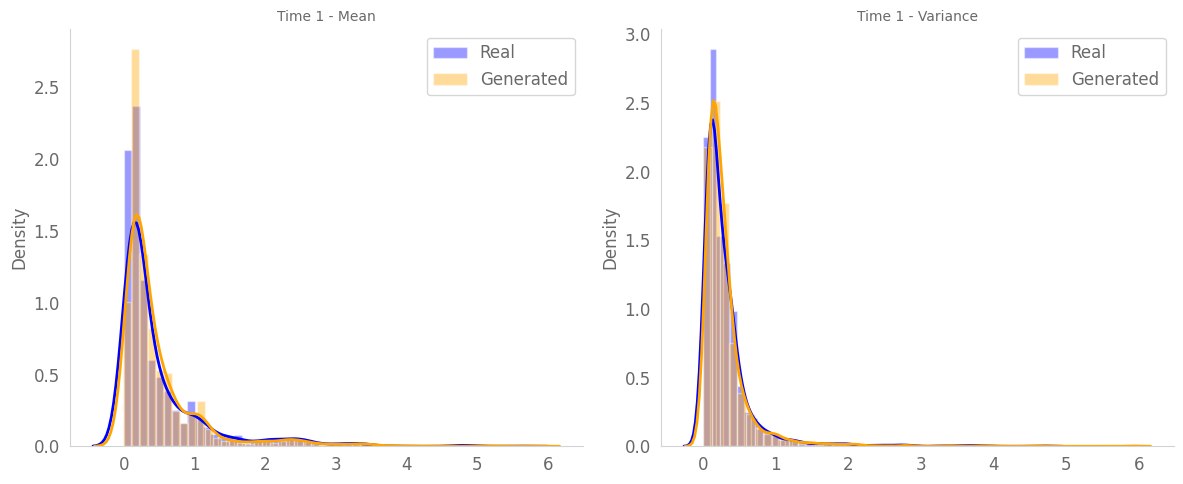

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_mean_var_histograms_kde_save(generated, df, save_dir="plots",name=None):
    """
    Plot histograms and KDEs of feature-wise mean and variance for real and generated data
    across multiple time points, and save the figures as PNG files.

    Args:
        generated (np.ndarray): Generated data array, shape (time, samples, features)
        df (pd.DataFrame): Real data DataFrame with a 'samples' column
        save_dir (str): Directory to save the figures
    """
    time_points = df["samples"].unique()
    num_timepoints = len(time_points)

    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    for i, t in enumerate(time_points):
        real_vals = df[df["samples"] == t].filter(like='x').values
        gen_vals = generated[i]

        real_mean = real_vals.mean(axis=0)
        gen_mean = gen_vals.mean(axis=0)
        real_var = real_vals.var(axis=0)
        gen_var = gen_vals.var(axis=0)

        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # --- Mean subplot ---
        ax_mean = axes[0]
        ax_mean.hist(real_mean, bins=50, alpha=0.4, label='Real', color='blue', density=True)
        ax_mean.hist(gen_mean, bins=50, alpha=0.4, label='Generated', color='orange', density=True)
        sns.kdeplot(real_mean, ax=ax_mean, color='blue', linewidth=2)
        sns.kdeplot(gen_mean, ax=ax_mean, color='orange', linewidth=2)
        ax_mean.set_title(f'Time {t} - Mean')
        ax_mean.legend()

        # --- Variance subplot ---
        ax_var = axes[1]
        ax_var.hist(real_var, bins=50, alpha=0.4, label='Real', color='blue', density=True)
        ax_var.hist(gen_var, bins=50, alpha=0.4, label='Generated', color='orange', density=True)
        sns.kdeplot(real_var, ax=ax_var, color='blue', linewidth=2)
        sns.kdeplot(gen_var, ax=ax_var, color='orange', linewidth=2)
        ax_var.set_title(f'Time {t} - Variance')
        ax_var.legend()

        plt.tight_layout()

        # Save figure
        fig_path = os.path.join(save_dir, f"time_{t}_mean_var_{name}.png")
        plt.savefig(fig_path, dpi=300)
        # plt.close(fig)  # Close figure to free memory



# Remove the first time point
timepoints = sorted(df['samples'].unique())
df_wo_first = df[df['samples'].isin(timepoints[1:])]
generated_wo_first = generated[1:, :, :]
generated_pretrain_wo_first = generate_pretrain[1:, :, :]

# Plot histograms and KDEs for the remaining time points
plot_mean_var_histograms_kde_save(generated_wo_first, df_wo_first,save_dir=exp_dir,name='final')
plot_mean_var_histograms_kde_save(generated_pretrain_wo_first, df_wo_first,save_dir=exp_dir,name='pretrain')


### Analysis on growth rate of different cell type 

We follow **Bastidas-Ponce et al. (2019)** to obtain the ground truth of cell type transitions. We assume the following cell type transitions are exclusively correct (denoted by →), i.e., there is no descending cell type (or set of cell types) other than the given one. We partition all considered cell type transitions into three categories.

##### Endocrine branch (ED) transitions

- Fev+ Alpha (**FA**) → Alpha (**A**)
- Fev+ Beta (**FB**) → Beta (**B**)
- Fev+ Delta (**FD**) → Delta (**D**)
- Fev+ Epsilon (**FE**) → Epsilon (**E**)
- A → A
- B → B
- D → D
- E → E

##### Ngn3 EP transitions

- Ngn3 high early (**NE**) → ED
- Ngn3 high late (**NL**) → ED

##### Non-endocrine branch (NEB) transitions

- Ductal (**DU**) → DU
- Tip (**T**) → Acinar (**AC**)
- AC → AC

In [64]:
import torch
import pandas as pd

def compute_g_at_time0(df_all, f_net, device='cpu'):
    """
    Compute g values for rows in df_all where 'samples' == 0 and
    return a new DataFrame containing ['samples', 'cell_type', 'branch', 'g'].

    Args:
        df_all (pd.DataFrame): Input DataFrame with features x1..xn and metadata columns
        f_net (torch.nn.Module): Model that returns (_, g) for input (t, data)
        device (str): Device to run torch tensors ('cpu' or 'cuda')

    Returns:
        pd.DataFrame: New DataFrame with columns ['samples', 'cell_type', 'branch', 'g']
    """
    # Select only rows where samples == 0
    df0 = df_all[df_all['samples'] == 0].copy()
    
    n = 2000  # Number of features
    column_names = [f'x{i}' for i in range(1, n + 1)]
    
    # Convert features to torch tensor
    data_tensor = torch.tensor(df0[column_names].values, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        t = torch.tensor([0], dtype=torch.float32).to(device)
        _, g = f_net(t, data_tensor)
    
    # Detach and convert to numpy
    g_values = g.detach().cpu().numpy().flatten()
    
    # Construct new DataFrame
    df_g = df0[['samples', 'cell_type', 'branch']].copy()
    df_g['g'] = g_values
    
    return df_g

# Example usage:
df_time0_g = compute_g_at_time0(df_all, f_net, device='cpu')
df_time0_g.head()


,samples,cell_type,branch,g
0,0,Beta,0,-0.871234
1,0,Acinar,2,0.451846
2,0,Acinar,2,0.350685
3,0,Beta,0,-0.120768
4,0,Fev+ Beta,0,-0.504450


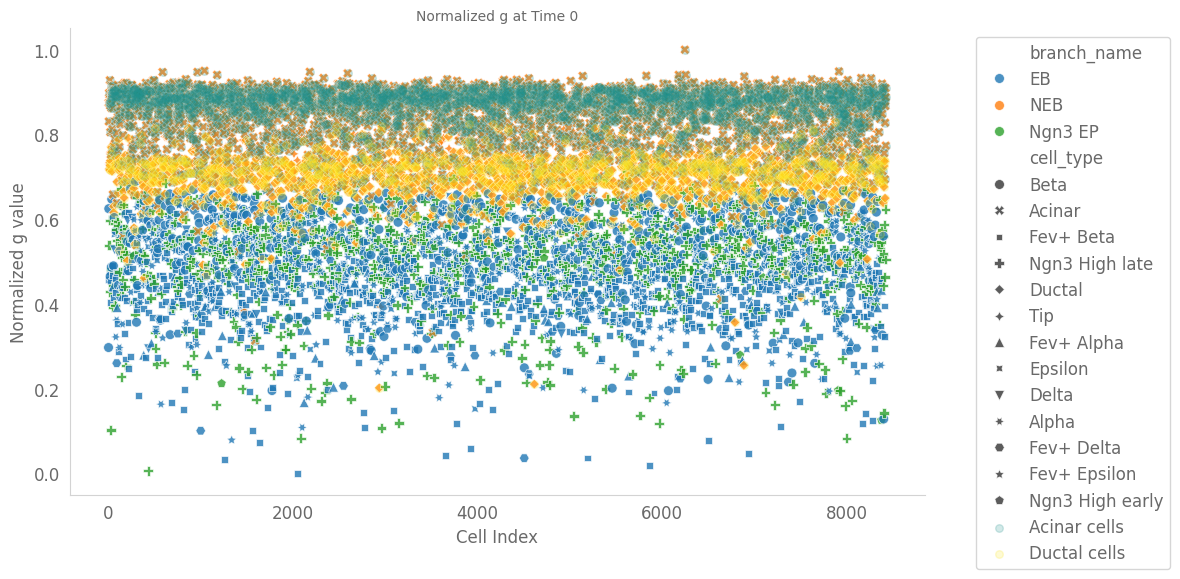

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

def scatter_g_by_cell_normalized(df_g, highlight_cell_types=['Acinar', 'Ductal'], title="Normalized g values per cell"):
    """
    Scatter plot of normalized g values per cell.
    
    Args:
        df_g (pd.DataFrame): DataFrame with columns ['samples', 'cell_type', 'branch', 'g']
        highlight_cell_types (list): List of cell types to highlight with marker
        title (str): Plot title
    """
    df_plot = df_g.copy().reset_index(drop=True)
    df_plot['cell_idx'] = df_plot.index
    branch_map = {0: 'EB', 1: 'Ngn3 EP', 2: 'NEB'}
    df_plot['branch_name'] = df_plot['branch'].map(branch_map)

    # Normalize g values to [0, 1]
    scaler = MinMaxScaler()
    df_plot['g_norm'] = scaler.fit_transform(df_plot[['g']])
    
    plt.figure(figsize=(12, 6))
    
    # Scatterplot with branch colors and cell_type markers
    sns.scatterplot(
        data=df_plot,
        x='cell_idx',
        y='g_norm',
        hue='branch_name',
        style='cell_type',
        palette='tab10',
        s=50,
        alpha=0.8
    )
    
    # Highlight specific cell types with edge
    for cell_type in highlight_cell_types:
        subset = df_plot[df_plot['cell_type'] == cell_type]
        plt.scatter(
            subset['cell_idx'],
            subset['g_norm'],
            label=f'{cell_type} cells',
            # edgecolor='black',
            s=30,
            alpha=0.2
        )
    
    plt.xlabel('Cell Index')
    plt.ylabel('Normalized g value')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage
scatter_g_by_cell_normalized(df_time0_g, highlight_cell_types=['Acinar', 'Ductal'], title="Normalized g at Time 0")


In this dataset, the proliferation observed during this developmental stage mainly originates from Acinar and Ductal cells. Remarkably, our model successfully recapitulates this pattern without being given any prior knowledge of the cell types, demonstrating its ability to infer biologically meaningful dynamics directly from the data.

We next demonstrate that the learned $g$ not only successfully recapitulates the relative growth rates of different cell types without any prior information about cell identities, but also that the branch-wise mass obtained from numerical integration of the ODE closely matches the total branch mass at time point 1.

In [92]:
from torchdiffeq import odeint_adjoint as odeint
from VGFM.models import ODEFunc2

time =  torch.Tensor(groups)
f_net=f_net.to(device)
data_t0 = torch.tensor(df[df['samples']==0].iloc[:,1:].values,dtype=torch.float32).to(device)
lnw0 = torch.log(torch.ones(data_t0.shape[0]) / data_t0.shape[0]).to(device)
initial_state_energy = (data_t0, lnw0)
_, generate_weights = odeint(ODEFunc2(f_net), initial_state_energy, time)

In [93]:
np.save(exp_dir+'/generated_weights_final.npy', generate_weights.detach().cpu().numpy())

In [103]:
generated_weights = np.load(exp_dir+'/generated_weights_final.npy')
df_time0_g['ln_weights_pred'] = generate_weights[1].detach().cpu().numpy()
df_time0_g['weights_pred'] = np.exp(df_time0_g['ln_weights_pred'])
df_time0_g

,samples,cell_type,branch,g,weights_pred,ln_weights_pred
0,0,Beta,0,-0.871234,0.000060,-9.721386
1,0,Acinar,2,0.451846,0.000200,-8.514730
2,0,Acinar,2,0.350685,0.000194,-8.548228
3,0,Beta,0,-0.120768,0.000106,-9.155956
4,0,Fev+ Beta,0,-0.504450,0.000083,-9.391547
...,...,...,...,...,...,...
8419,0,Ngn3 High late,1,-0.123923,0.000115,-9.067032
8420,0,Acinar,2,0.530747,0.000220,-8.422276
8421,0,Ngn3 High late,1,-0.395737,0.000085,-9.367807
8422,0,Acinar,2,0.220156,0.000197,-8.529827


In [142]:
df_time0_g.groupby('branch')['weights_pred'].sum()

branch
0    0.205272
1    0.096766
2    0.906271
Name: weights_pred, dtype: float32

In [157]:
df_time1 = df_all[df_all['samples']==1].copy()
df_time1['weights'] = 1/len(df_time0_g)
df_time0_g['weights'] = 1/len(df_time0_g)
df_summary_0 = df_time0_g[['weights','weights_pred']].groupby(df_time0_g['branch']).sum()
df_summary_1 = df_time1[['weights']].groupby(df_time1['branch']).sum()
df_summary = pd.merge(df_summary_0, df_summary_1, left_index=True, right_index=True, suffixes=('_time0', '_time1'))
df_summary

,weights_time0,weights_pred,weights_time1
branch,,,
0,0.287156,0.205272,0.152422
1,0.127255,0.096766,0.076211
2,0.585589,0.906271,0.955128


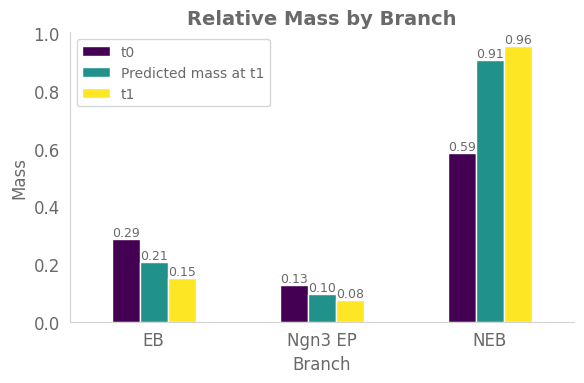

In [158]:
import matplotlib.pyplot as plt
import os

# Map branch indices to biological names
branch_map = {0: 'EB', 1: 'Ngn3 EP', 2: 'NEB'}
df_summary.index = df_summary.index.map(branch_map)

# Plot bar chart for mass comparison
ax = df_summary.plot(
    kind='bar',
    xlabel='Branch',
    ylabel='Mass',
    figsize=(6, 4)
)

# Add numerical labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.2f}',  # format the number
        (p.get_x() + p.get_width() / 2, height),
        ha='center', va='bottom',
        fontsize=9
    )

# Customize legend: rename and format
handles, labels = ax.get_legend_handles_labels()
new_labels = ['t0', 'Predicted mass at t1', 't1']
ax.legend(handles, new_labels, fontsize=10, title_fontsize=12)

# Add title and improve figure layout
ax.set_title('Relative Mass by Branch', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()

# Save figure
plt.savefig(os.path.join(exp_dir, 'branch_mass_comparison.png'), dpi=300)
plt.show()


### Analysis on key genes based on $g$

In [40]:
df_gene = pd.read_csv(DATA_DIR + '/pancrease_2000d.csv')
gene_names = df_gene.columns[3:]
gene_names.shape

(2000,)

In [50]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def g_genes(df, f_net, gene_names, device=device):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 2000
        column_names = [f'x{i}' for i in range(1, n + 1)]
        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]
        data = torch.stack(tensors, dim=1)
        data.requires_grad = True
        t = torch.tensor([time], dtype=torch.float32).to(device)
        _, g = f_net(t, data)
        grads = torch.autograd.grad(
                outputs=g,
                inputs=data,
                grad_outputs=torch.ones_like(g),
                create_graph=False,
                retain_graph=False,
                only_inputs=True
            )[0]

        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy(), 'grad_g_abs': grads.abs().mean(dim=0).detach().cpu().numpy()}
        grad_mean=grads.abs().mean(dim=0).detach().cpu().numpy()
        top10_indices = np.argsort(grad_mean)[::-1][:10] 
        top10_genes = [gene_names[i] for i in top10_indices]
        print(time)
        print(top10_genes)
    
    

g_genes(df, f_net, gene_names)

0
['Malat1', 'Neurog3', 'Mfap4', 'Map1b', 'Pnliprp1', 'Gnas', 'Igfbpl1', 'Btbd17', 'Actb', 'Ctrb1']
1
['Malat1', 'Pnliprp1', 'mt-Co3', 'Sparc', 'Fscn1', 'Clps', 'Actb', 'mt-Atp6', 'Reep5', 'Cxcl12']


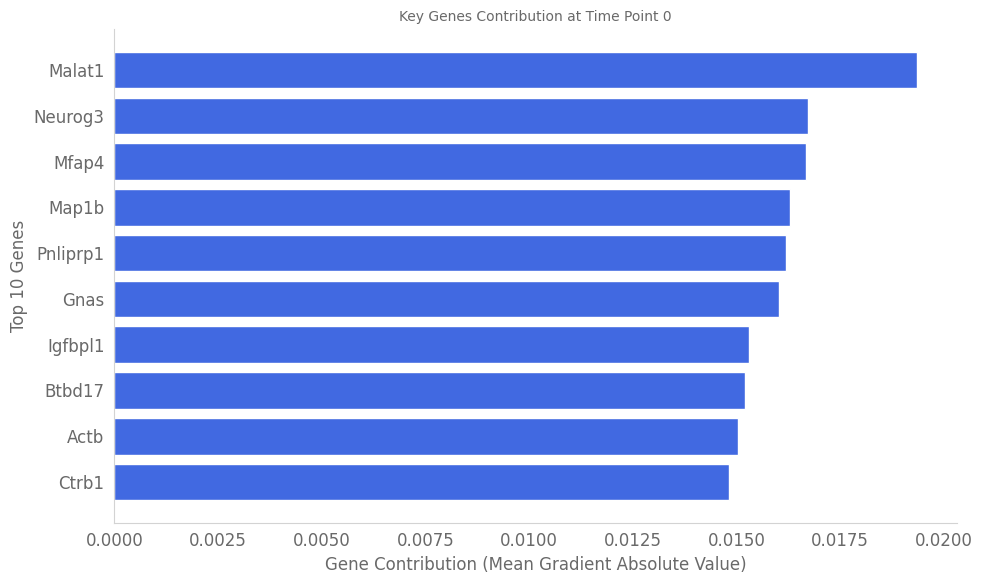

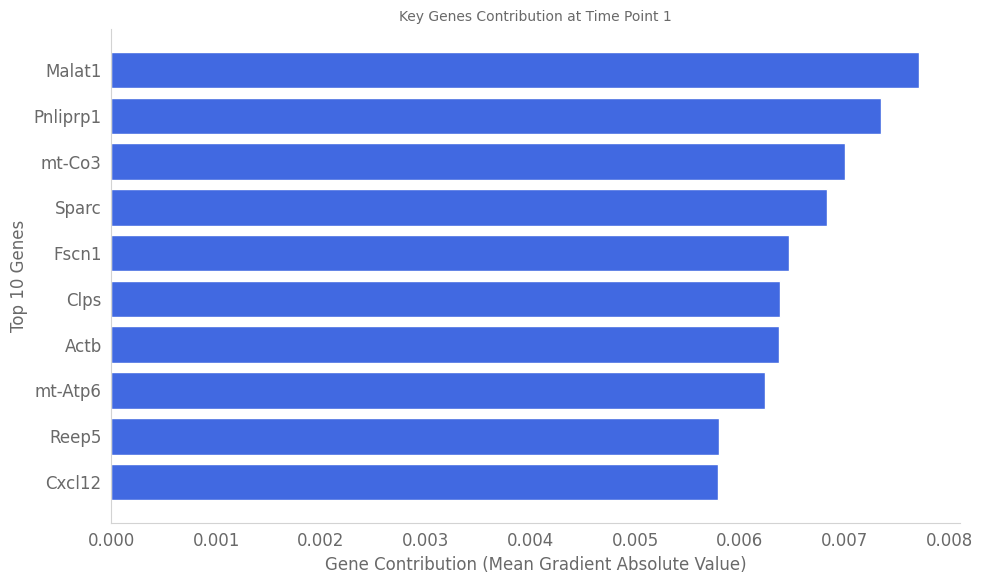

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def g_genes(df, f_net, gene_names, device='cpu'):
    # Extract unique time points from the 'samples' column
    time_points = df['samples'].unique()
    data_by_time = {}

    # Iterate over each time point to calculate gene contributions
    for time in time_points:
        subset = df[df['samples'] == time]  # Subset of data for the current time point
        n = 2000  # Number of features/genes to consider
        column_names = [f'x{i}' for i in range(1, n + 1)]  # Column names for gene expression

        # Convert dataframe columns to torch tensors and move to the specified device
        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]
        data = torch.stack(tensors, dim=1)  # Stack tensors into a single 2D tensor
        data.requires_grad = True  # Enable gradient computation with respect to input

        t = torch.tensor([time], dtype=torch.float32).to(device)  # Time input for the model

        # Forward pass through the model and obtain output g
        _, g = f_net(t, data)

        # Compute gradient of g with respect to input features
        grads = torch.autograd.grad(
                outputs=g,
                inputs=data,
                grad_outputs=torch.ones_like(g),
                create_graph=False,
                retain_graph=False,
                only_inputs=True
            )[0]

        # Compute mean absolute gradient for each gene
        grad_mean = grads.abs().mean(dim=0).detach().cpu().numpy()
        
        # Identify top 10 genes with the highest contribution
        top10_indices = np.argsort(grad_mean)[::-1][:10] 
        top10_genes = [gene_names[i] for i in top10_indices]
        top10_contributions = grad_mean[top10_indices]
        
        # Store results for the current time point
        data_by_time[time] = {
            'data': subset,
            'g_values': g.detach().cpu().numpy(),
            'grad_g_abs': grad_mean
        }

        # Plot the top 10 gene contributions for this time point
        plt.figure(figsize=(10, 6))
        plt.barh(top10_genes, top10_contributions, color='royalblue')
        plt.xlabel('Gene Contribution (Mean Gradient Absolute Value)')
        plt.ylabel('Top 10 Genes')
        plt.title(f'Key Genes Contribution at Time Point {time}')
        plt.gca().invert_yaxis()  # Display the highest-contributing gene at the top
        plt.tight_layout()
        plt.show()

# Example usage assuming df, f_net, and gene_names are already defined
g_genes(df, f_net, gene_names)


In this stage, It is known that Acinar and Ductal cells have very high proliferation rates.


#### timepoint 0
- **Malat1** [RELEVANT] - Long non-coding RNA highly expressed in rapidly proliferating cells; regulates cell cycle and proliferation-related genes
- **Neurog3** [REQUIRES VALIDATION] - Endocrine precursor cell marker; presence during acinar/ductal proliferation requires validation
- **Mfap4** [UNCLEAR SIGNIFICANCE] - Microfibril-associated protein; function in pancreatic development not well characterized
- **Map1b** [RELEVANT] - Microtubule-associated protein involved in cytoskeletal reorganization; necessary for cell division
- **Pnliprp1** [RELEVANT] - Pancreatic lipase-related protein, acinar cell marker; increased expression during high proliferation periods
- **Gnas** [RELEVANT] - G-protein alpha subunit; involved in cell proliferation signaling pathways
- **Igfbpl1** [REQUIRES VALIDATION] - IGF-binding protein-like 1; potentially involved in growth regulation
- **Btbd17** [UNCLEAR SIGNIFICANCE] - Function poorly characterized in pancreatic development
- **Actb** [RELEVANT] - Beta-actin; cytoskeletal foundation highly expressed in active cells
- **Ctrb1** [RELEVANT] - Chymotrypsinogen B1; acinar cell-specific digestive enzyme

#### timepoint 1
- **Malat1** [RELEVANT] - Proliferation-associated lncRNA
- **Pnliprp1** [RELEVANT] - Acinar cell marker
- **mt-Co3** [RELEVANT] - Mitochondrial cytochrome c oxidase; reflects high metabolic activity supporting rapid proliferation
- **Sparc** [RELEVANT] - Secreted protein acidic and rich in cysteine; associated with cell proliferation and tissue remodeling
- **Fscn1** [RELEVANT] - Fascin1, actin-binding protein; involved in cell motility and proliferation
- **Clps** [RELEVANT] - Colipase; acinar cell marker supporting digestive enzyme production
- **Actb** [RELEVANT] - Cytoskeletal protein
- **mt-Atp6** [RELEVANT] - Mitochondrial ATP synthase; indicates high energy demands for proliferation
- **Reep5** [RELEVANT] - Receptor expression-enhancing protein; supports endoplasmic reticulum function and protein synthesis
- **Cxcl12** [REQUIRES VALIDATION] - Chemokine; may participate in cell migration and positioning during development

#### **Important Note**

It is important to acknowledge that the analysis presented here was conducted from a non-specialist perspective in biology. The interpretations of gene functions are based primarily on computational predictions, annotations from public databases and author's own understanding. As such, these conclusions should be considered preliminary and hypothesis-generating. The true biological rationale and significance of these findings would benefit greatly from further validation through experimental methods and, most importantly, critical review by experts in developmental biology and molecular genetics. We welcome any corrections and more nuanced interpretations from the research community.